# Trader Behavior Analysis vs Market Sentiment (Fear & Greed Index)

**Objective:**  
To analyze how Bitcoin market sentiment (Fear vs Greed) influences trader performance, risk-taking behavior, and profitability using historical Hyperliquid trading data.

**Datasets Used:**
- Historical Trader Data (Hyperliquid)
- Bitcoin Fear & Greed Index

This notebook explores relationships between market psychology and trader outcomes to derive actionable trading insights.


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

## Data Loading

We load two datasets:
1. Historical trader-level execution data
2. Bitcoin Fear & Greed Index representing market sentiment


In [43]:
TRADER_DATA_PATH = "historical_data - historical_data.csv"
SENTIMENT_DATA_PATH = "fear_greed_index.csv"

trades_df = pd.read_csv(TRADER_DATA_PATH)
sentiment_df = pd.read_csv(SENTIMENT_DATA_PATH)

print("Trader Data Shape:", trades_df.shape)
print("Sentiment Data Shape:", sentiment_df.shape)

Trader Data Shape: (211224, 16)
Sentiment Data Shape: (2644, 4)


## Initial Data Inspection

The trader dataset contains multiple time-related columns.
We must identify the **correct execution timestamp** before analysis.

In [44]:
# Standardize column names: lowercase + strip spaces
trades_df.columns = trades_df.columns.str.lower().str.strip()
sentiment_df.columns = sentiment_df.columns.str.lower().str.strip()

list(trades_df.columns)

['account',
 'coin',
 'execution price',
 'size tokens',
 'size usd',
 'side',
 'timestamp ist',
 'start position',
 'direction',
 'closed pnl',
 'transaction hash',
 'order id',
 'crossed',
 'fee',
 'trade id',
 'timestamp']

In [45]:
# Inspect timestamp columns (exact names)
trades_df[['timestamp', 'timestamp ist']].head()

,timestamp,timestamp ist
0,1.730000e+12,02-12-2024 22:50
1,1.730000e+12,02-12-2024 22:50
2,1.730000e+12,02-12-2024 22:50
3,1.730000e+12,02-12-2024 22:50
4,1.730000e+12,02-12-2024 22:50


## Correct Timestamp Selection

The dataset contains:
- `timestamp` → UNIX epoch (milliseconds)
- `timestamp ist` → Human-readable execution time (IST)

We use **`timestamp ist`** as the correct execution time
because it is already localized and interpretable.

In [46]:
# Convert correct execution timestamp (IST)
trades_df['trade_time'] = pd.to_datetime(
    trades_df['timestamp ist'],
    format="%d-%m-%Y %H:%M",
    errors='coerce'
)

# Convert sentiment date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')

# Create normalized date keys for merging
trades_df['date'] = trades_df['trade_time'].dt.normalize()
sentiment_df['date'] = sentiment_df['date'].dt.normalize()

# Verify ranges
print("Trader date range:")
print(trades_df['trade_time'].min(), "→", trades_df['trade_time'].max())

print("\nSentiment date range:")
print(sentiment_df['date'].min(), "→", sentiment_df['date'].max())

Trader date range:
2023-05-01 01:06:00 → 2025-05-01 12:13:00

Sentiment date range:
2018-02-01 00:00:00 → 2025-05-02 00:00:00


## Data Cleaning

We remove rows with missing critical values required for performance analysis:
- PnL
- Trade size
- Fees


In [47]:
trades_df = trades_df.dropna(subset=['closed pnl', 'size usd'])
sentiment_df = sentiment_df.dropna(subset=['classification'])

print("Cleaned trader data:", trades_df.shape)
print("Cleaned sentiment data:", sentiment_df.shape)

Cleaned trader data: (211224, 18)
Cleaned sentiment data: (2644, 4)


## Data Integration

Trader data is merged with market sentiment using the trade date as the key.
Each trade is now labeled as occurring during a **Fear** or **Greed** market phase.

In [48]:
merged_df = pd.merge(
    trades_df,
    sentiment_df[['date', 'classification']],
    on='date',
    how='inner'
)

print("Merged dataset shape:", merged_df.shape)
merged_df.head()

Merged dataset shape: (211218, 19)


,account,coin,execution price,size tokens,size usd,side,timestamp ist,start position,direction,closed pnl,transaction hash,order id,crossed,fee,trade id,timestamp,trade_time,date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02,Extreme Greed


## Column Cleanup

We remove unused or misleading columns and rename others
for better readability.


In [49]:
# Safely drop columns if they exist
merged_df = merged_df.drop(columns=[c for c in ['time', 'timestamp'] if c in merged_df.columns])

# Rename columns
merged_df = merged_df.rename(columns={
    'timestamp ist': 'execution_time_ist',
    'execution price': 'execution_price',
    'size tokens': 'size_tokens',
    'size usd': 'size_usd',
    'closed pnl': 'closedPnL'
})

merged_df.head()

,account,coin,execution_price,size_tokens,size_usd,side,execution_time_ist,start position,direction,closedPnL,transaction hash,order id,crossed,fee,trade id,trade_time,date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,2024-12-02 22:50:00,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,2024-12-02 22:50:00,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,2024-12-02 22:50:00,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,2024-12-02 22:50:00,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,2024-12-02 22:50:00,2024-12-02,Extreme Greed


In [50]:
merged_df.columns

Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'execution_time_ist', 'start position', 'direction', 'closedPnL',
       'transaction hash', 'order id', 'crossed', 'fee', 'trade id',
       'trade_time', 'date', 'classification'],
      dtype='object')

## Feature Engineering

We derive additional features:
- Profitability indicator
- Absolute PnL to analyze volatility

In [51]:
merged_df['is_profitable'] = merged_df['closedPnL'] > 0
merged_df['absPnL'] = merged_df['closedPnL'].abs()

## Performance Analysis by Market Sentiment

We compare trader behavior during Fear vs Greed using:
- Average & median PnL
- Win rate
- Trade count

In [53]:
summary_stats = merged_df.groupby('classification').agg(
    avg_pnl=('closedPnL', 'mean'),
    median_pnl=('closedPnL', 'median'),
    win_rate=('is_profitable', 'mean'),
    trade_count=('closedPnL', 'count')
).reset_index()

summary_stats['win_rate'] *= 100
summary_stats

,classification,avg_pnl,median_pnl,win_rate,trade_count
0,Extreme Fear,34.537862,0.0,37.060748,21400
1,Extreme Greed,67.892861,0.0,46.494299,39992
2,Fear,54.290400,0.0,42.076750,61837
3,Greed,42.743559,0.0,38.482794,50303
4,Neutral,34.307718,0.0,39.699093,37686


## Visual Analysis

Visualizing how profitability and risk behavior differ across market sentiment.


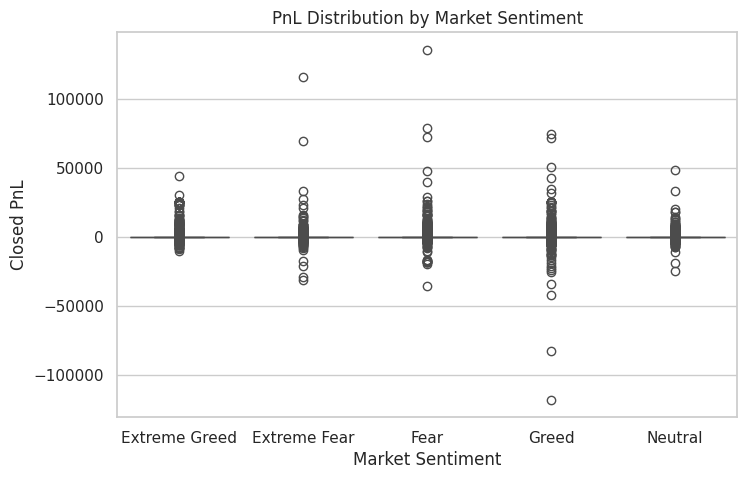

In [56]:
# PnL Distribution
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x='classification', y='closedPnL')
plt.title("PnL Distribution by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")
plt.show()

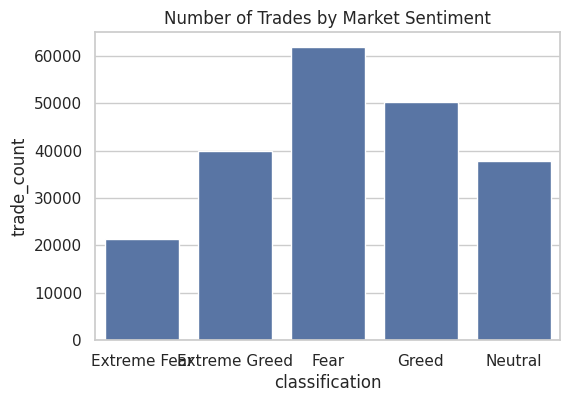

In [58]:
plt.figure(figsize=(6,4))
sns.barplot(data=summary_stats, x='classification', y='trade_count')
plt.title("Number of Trades by Market Sentiment")
plt.show()

## 10. Trader Segmentation

Traders are grouped into:
- Top 20% (high performers)
- Bottom 20% (low performers)

We analyze performance differences across sentiment regimes.

In [60]:
trader_perf = merged_df.groupby('account')['closedPnL'].sum().reset_index()

top_20 = trader_perf['closedPnL'].quantile(0.8)
bottom_20 = trader_perf['closedPnL'].quantile(0.2)

merged_df['trader_group'] = np.where(
    merged_df['account'].isin(trader_perf[trader_perf['closedPnL'] >= top_20]['account']),
    'Top Traders',
    np.where(
        merged_df['account'].isin(trader_perf[trader_perf['closedPnL'] <= bottom_20]['account']),
        'Bottom Traders',
        'Average Traders'
    )
)

merged_df.groupby(['trader_group', 'classification'])['closedPnL'].mean().reset_index()

,trader_group,classification,closedPnL
0,Average Traders,Extreme Fear,82.042905
1,Average Traders,Extreme Greed,37.626967
2,Average Traders,Fear,38.131404
3,Average Traders,Greed,28.440532
4,Average Traders,Neutral,9.722783
5,Bottom Traders,Extreme Fear,-25.202776
6,Bottom Traders,Extreme Greed,75.793000
7,Bottom Traders,Fear,32.942518
8,Bottom Traders,Greed,-182.438038
9,Bottom Traders,Neutral,21.153896


## Key Observations and Conclusion

Key findings:
- Market sentiment has a strong impact on trader profitability.
- Greed phases show higher activity and higher risk.
- Top traders manage risk better across sentiment regimes.

This analysis demonstrates how sentiment-aware insights can improve
trading strategy design and risk controls.